In [25]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display import display

In [6]:
file_path = "~/Desktop/ethics_AI/ca_doj_deaths_in_custody_raw_1980-2015_05-14-2016.csv"

In [7]:
df = pd.read_csv(file_path)

In [8]:
print(df.head())

        county reporting_agency                         agency_full_name  \
0  Los Angeles           Police            Los Angeles Police Department   
1  Los Angeles           Police            Los Angeles Police Department   
2  Los Angeles          Sheriff  Los Angeles County Sheriff's Department   
3  Los Angeles          Sheriff  Los Angeles County Sheriff's Department   
4       Fresno          Sheriff       Fresno County Sheriff's Department   

   ncic_number_county ncic_number_city ncic_number_agency  date_of_birth_mm  \
0                  19               42                  0                 0   
1                  19               42                  0                 0   
2                  19                0                  0                 1   
3                  19                0                  0                 7   
4                  10                0                  0                 3   

   date_of_birth_dd date_of_birth_yyyy      race  ...  \
0          

In [17]:
# Generate lists for each date, whether birth or death
birth_dates = []
death_dates = []

# Iterate over entire dataframe, and pick out the birth and death dates, to generate an approximation of age at death (where possible)
for idx, row in df.iterrows():
    # Handle date of birth columns, merge and address "nulls" present
    y, m, d = row['date_of_birth_yyyy'], row['date_of_birth_mm'], row['date_of_birth_dd']
    try:
        y = int(y) if str(y).lower() != 'unk' else 0 # take the year as an int, unless the string "Unk" is present, then make the year 0
        m = max(1, int(m)) # take the month as is, unless it's 0, then make it 1
        d = max(1, int(d)) # take the day as is, unless its 0, then makke it 1
        total_birth_date = datetime(y, m, d) if y > 0 else pd.NaT # make the date an NaT if the year is unknown
    except (ValueError, TypeError): #exception handling if anything fails
        total_birth_date = pd.NaT
    birth_dates.append(total_birth_date) # put it all together

    # Handle date of death columns, merge and address "nulls" present
    y, m, d = row['date_of_death_yyyy'], row['date_of_death_mm'], row['date_of_death_dd']
    try:
        y = int(y) if str(y).lower() != 'unk' else 0 # if year is unknown, make the year 0, else just take it as it is
        m = max(1, int(m)) # if month is 0, fill in 1
        d = max(1, int(d)) # if day is 0, fill in 1
        total_death_date = datetime(y, m, d) if y > 0 else pd.NaT # if year is zero, make NaT, otherwise just process normally
    except (ValueError, TypeError): # error handling for everything else
        total_death_date = pd.NaT
    death_dates.append(total_death_date) # put it all together

# Make new integrated columns for each birth and death dates
df['date_of_birth'] = birth_dates
df['date_of_death'] = death_dates

# Calculate approximate age at death where possible
df['age_at_death'] = (df['date_of_death'] - df['date_of_birth']).dt.days / 365.25

#round down to nearest integer, so we don't get something like 36.9999999 and instead get 36
df['age_at_death'] = np.floor(df['age_at_death']).astype('Int64')

# Preview age result
df[['date_of_birth', 'date_of_death', 'age_at_death']].head()

# drop the redundant columns of birth and death
df = df.drop(columns=[
    'date_of_birth_mm', 'date_of_birth_dd', 'date_of_birth_yyyy',
    'date_of_death_mm', 'date_of_death_dd', 'date_of_death_yyyy'
])

In [19]:
print(df.head())

        county reporting_agency                         agency_full_name  \
0  Los Angeles           Police            Los Angeles Police Department   
1  Los Angeles           Police            Los Angeles Police Department   
2  Los Angeles          Sheriff  Los Angeles County Sheriff's Department   
3  Los Angeles          Sheriff  Los Angeles County Sheriff's Department   
4       Fresno          Sheriff       Fresno County Sheriff's Department   

   ncic_number_county ncic_number_city ncic_number_agency      race gender  \
0                  19               42                  0     White   Male   
1                  19               42                  0  Hispanic   Male   
2                  19                0                  0     Black   Male   
3                  19                0                  0     Black   Male   
4                  10                0                  0  Hispanic   Male   

            custody_status  custody_offense  \
0               In Transit 

In [21]:
# Standardizing the categories for easieerr processing
validated_manners = ['Suicide', 'Natural', 'Accidental', 'Homicide', 'Cannot Be Determined']
validated_custody = [
    'Sentenced', 
    'Awaiting Booking', 
    'Booked – Awaiting Trial', 
    'Booked – No Charges Filed'
]

# Create categories for 'manner_of_death'
# method below inspired by https://stackoverflow.com/questions/42145340/using-lambda-conditional-and-pandas-str-contains-to-lump-strings
df['manner_of_death'] = df['manner_of_death'].astype(str).str.title().str.strip()
df['manner_of_death'] = df['manner_of_death'].apply(
    lambda x: x if x in validated_manners else 'Other'
)

# Create categories for 'custody_status'
# method below inspired by https://stackoverflow.com/questions/42145340/using-lambda-conditional-and-pandas-str-contains-to-lump-strings
df['custody_status'] = df['custody_status'].astype(str).str.title().str.strip()
df['custody_status'] = df['custody_status'].apply(
    lambda x: x if x in validated_custody else 'Other'
)

# Verify changes for the two dependent variables
df[['manner_of_death', 'custody_status']].value_counts()

# independent variables (protected classes)
# race, gender, age (at death)

manner_of_death       custody_status  
Natural               Sentenced           8312
                      Other               1725
Other                 Other               1704
Suicide               Sentenced           1106
                      Other               1050
Accidental            Other                755
Other                 Sentenced            662
Accidental            Sentenced            426
                      Awaiting Booking     117
Cannot Be Determined  Other                 83
Suicide               Awaiting Booking      47
Cannot Be Determined  Sentenced             46
Natural               Awaiting Booking      46
Other                 Awaiting Booking      19
Cannot Be Determined  Awaiting Booking       3
Name: count, dtype: int64

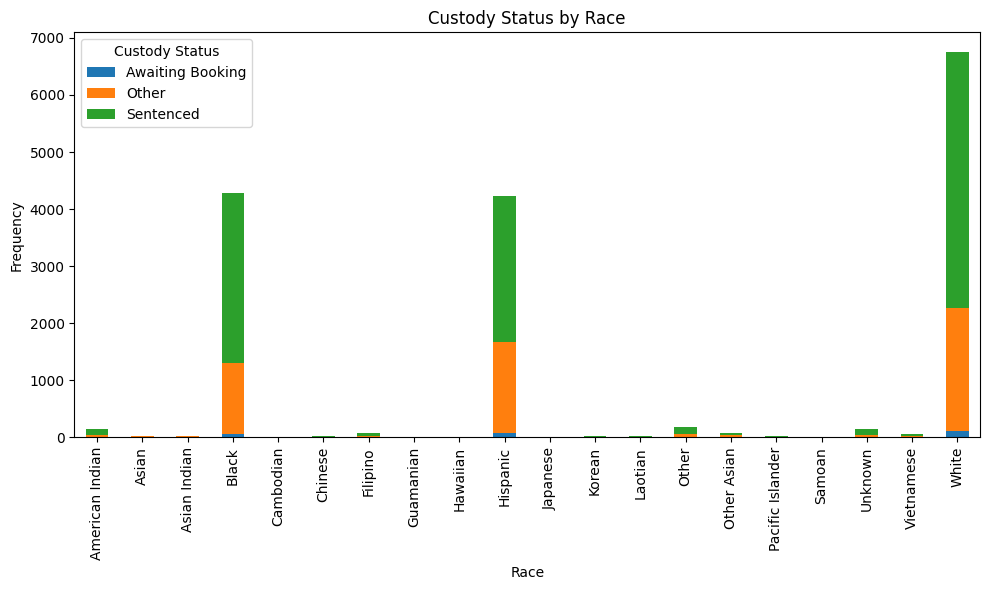

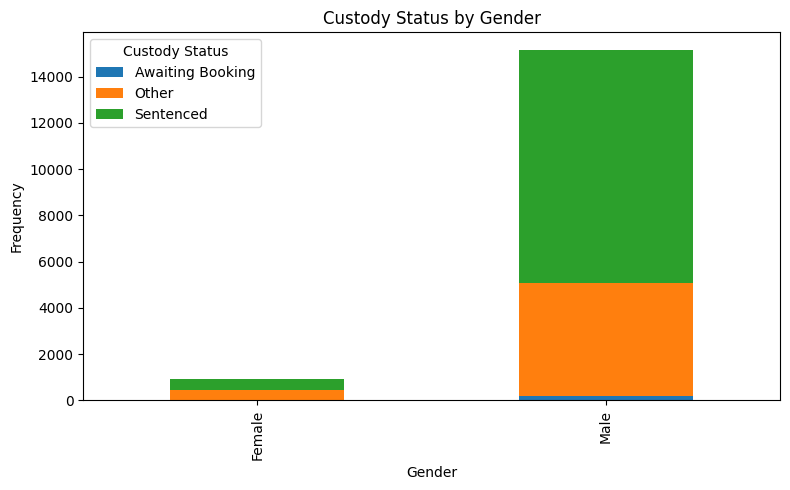

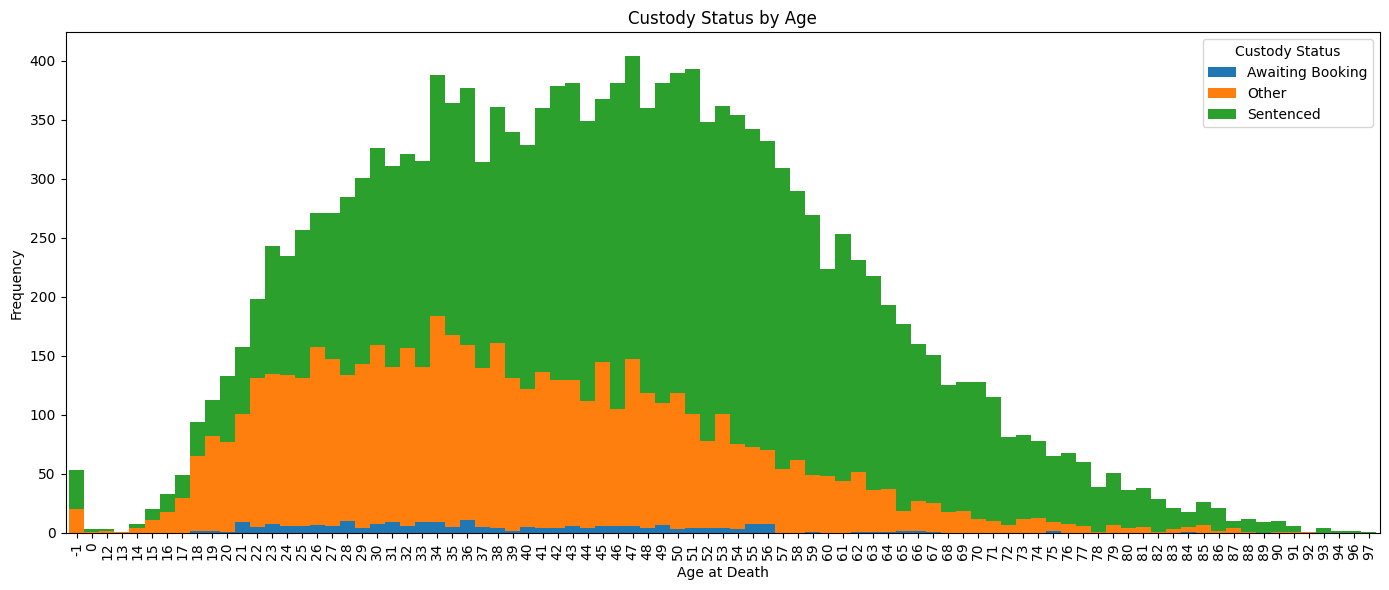

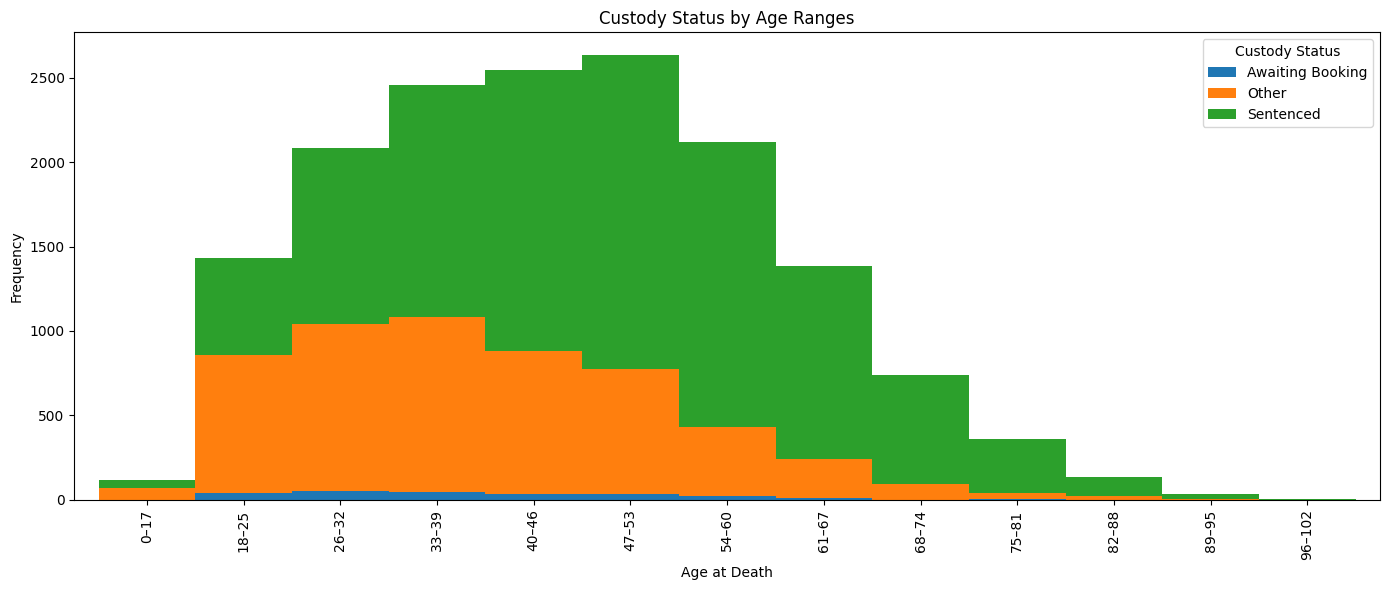

In [36]:
# fill na's for integer work later on
df['age_at_death'] = df['age_at_death'].fillna(-1).astype(int)

# Define descriptive bin cutoffs for easier cleaning
age_binning_cutoffs = [0, 18] + list(range(26, df['age_at_death'].max() + 8, 7))  # 0-17, 18–25, 25-33, etc.

# Define descriptive bin labels iteratively
# concept inspired originally by this article: https://stackoverflow.com/questions/72542196/change-range-of-age-groups
age_binning_labels = []
for i in range(len(age_binning_cutoffs) - 1):
    starting = age_binning_cutoffs[i]
    ending = age_binning_cutoffs[i + 1] - 1  # Make upper bound inclusive for purposes of analysis
    labeling = f"{starting}–{ending}"
    age_binning_labels.append(labeling)

# Apply age binning to DataFrame
df['age_of_death_bins'] = pd.cut(df['age_at_death_int'], bins=age_binning_cutoffs, labels=age_binning_labels, right=False)

# Crosstabs
ct_race_custody = pd.crosstab(df['race'], df['custody_status'])
ct_gender_custody = pd.crosstab(df['gender'], df['custody_status'])
ct_age_custody = pd.crosstab(df['age_at_death'].astype(int), df['custody_status'])
ct_age_custody_bins = pd.crosstab(df['age_of_death_bins'], df['custody_status'])

# Plot Race vs Custody Status
ct_race_custody.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Custody Status by Race')
plt.ylabel('Frequency')
plt.xlabel('Race')
plt.legend(title='Custody Status')
plt.tight_layout()
plt.savefig("race_custody_status.png", dpi=300)
plt.show()

# Plot Gender vs Custody Status
ct_gender_custody.plot(kind='bar', stacked=True, figsize=(8,5))
plt.title('Custody Status by Gender')
plt.ylabel('Frequency')
plt.xlabel('Gender')
plt.legend(title='Custody Status')
plt.tight_layout()
plt.savefig("gender_custody_status.png", dpi=300)
plt.show()

# Plot Age vs Custody Status
ct_age_custody.plot(kind='bar', stacked=True, figsize=(14,6), width=1)
plt.title('Custody Status by Age')
plt.ylabel('Frequency')
plt.xlabel('Age at Death')
plt.legend(title='Custody Status')
plt.tight_layout()
plt.savefig("age_custody_status.png", dpi=300)
plt.show()

# Plot Age Bins vs Custody Status
ct_age_custody_bins.plot(kind='bar', stacked=True, figsize=(14,6), width=1)
plt.title('Custody Status by Age Ranges')
plt.ylabel('Frequency')
plt.xlabel('Age at Death')
plt.legend(title='Custody Status')
plt.tight_layout()
plt.savefig("age_bins_custody_status.png", dpi=300)
plt.show()

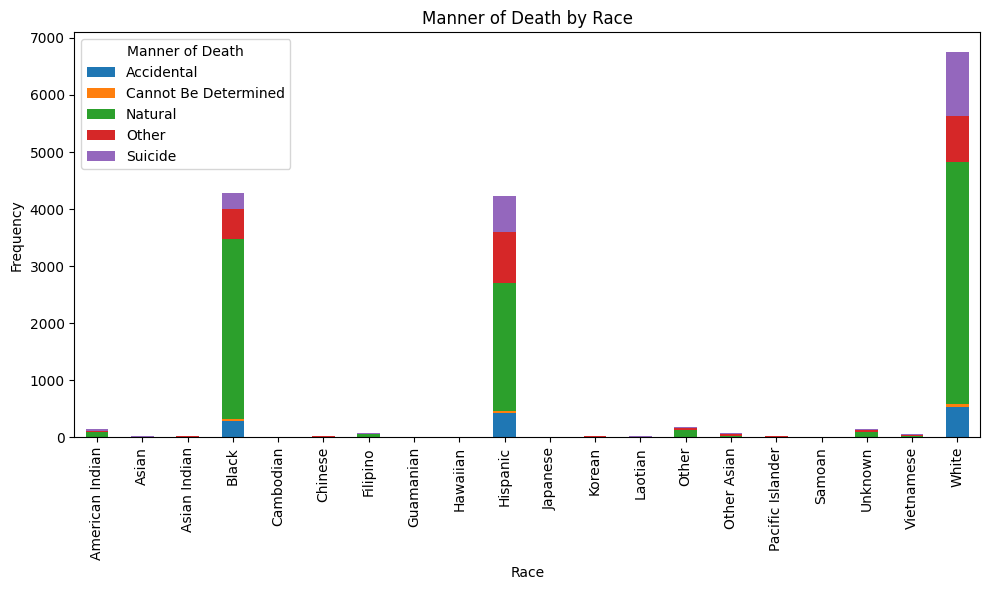

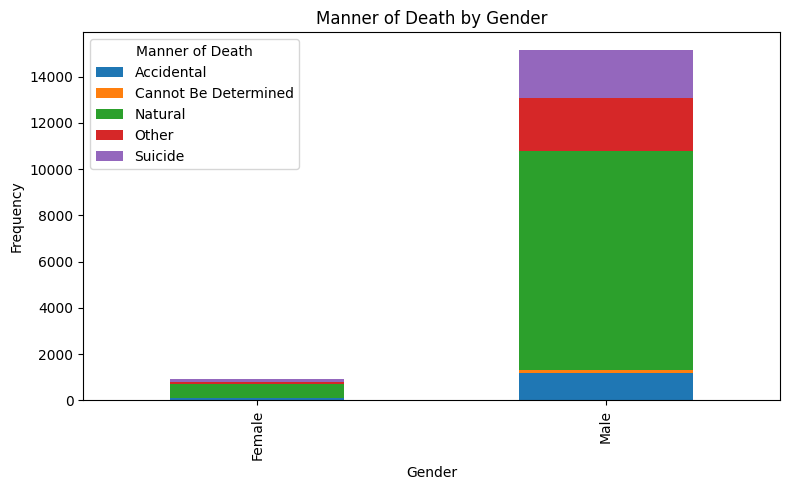

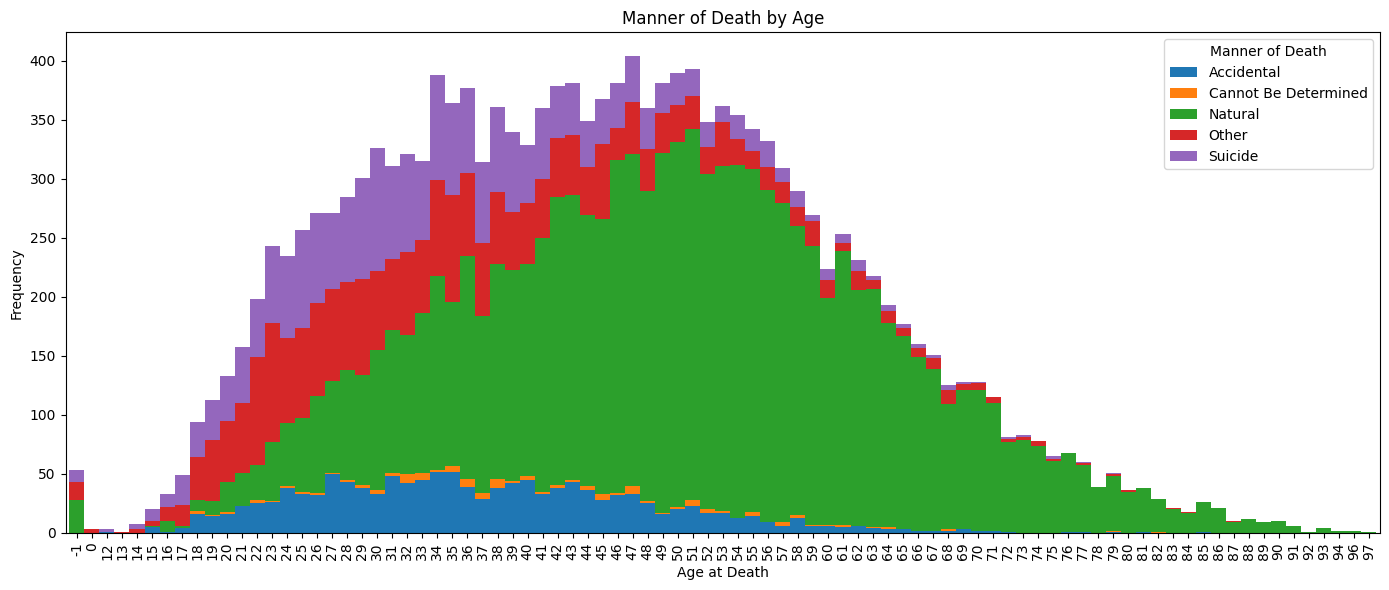

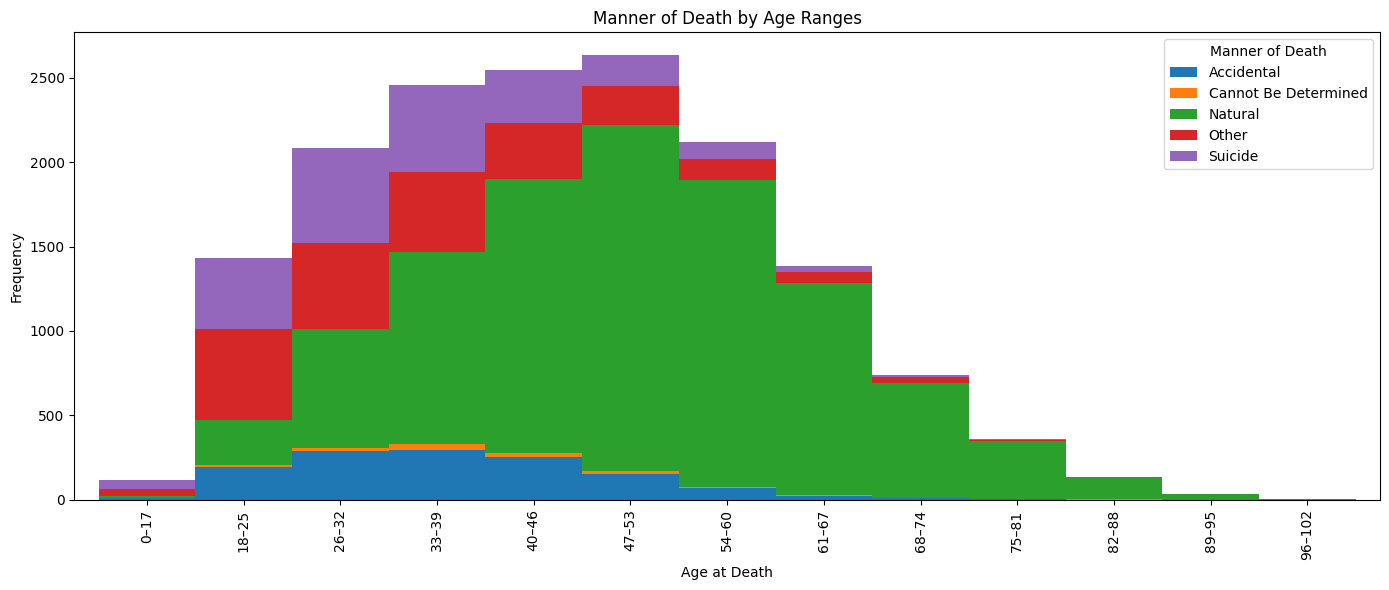

In [37]:
# Crosstabs
ct_race_death = pd.crosstab(df['race'], df['manner_of_death'])
ct_gender_death = pd.crosstab(df['gender'], df['manner_of_death'])
ct_age_death = pd.crosstab(df['age_at_death'].astype(int), df['manner_of_death'])
ct_age_death_bins = pd.crosstab(df['age_of_death_bins'], df['manner_of_death'])

# Plot Race vs Manner of Death
ct_race_death.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Manner of Death by Race')
plt.ylabel('Frequency')
plt.xlabel('Race')
plt.legend(title='Manner of Death')
plt.tight_layout()
plt.savefig("race_death.png", dpi=300)
plt.show()


# Plot Gender vs Manner of Death
ct_gender_death.plot(kind='bar', stacked=True, figsize=(8,5))
plt.title('Manner of Death by Gender')
plt.ylabel('Frequency')
plt.xlabel('Gender')
plt.legend(title='Manner of Death')
plt.tight_layout()
plt.savefig("gender_death.png", dpi=300)
plt.show()


# Plot Age vs Manner of Death
ct_age_death.plot(kind='bar', stacked=True, figsize=(14,6), width=1)
plt.title('Manner of Death by Age')
plt.ylabel('Frequency')
plt.xlabel('Age at Death')
plt.legend(title='Manner of Death')
plt.tight_layout()
plt.savefig("age_death.png", dpi=300)
plt.show()


# Plot Age Bins vs Manner of Death
ct_age_death_bins.plot(kind='bar', stacked=True, figsize=(14,6), width=1)
plt.title('Manner of Death by Age Ranges')
plt.ylabel('Frequency')
plt.xlabel('Age at Death')
plt.legend(title='Manner of Death')
plt.tight_layout()
plt.savefig("age_bins_death.png", dpi=300)
plt.show()


In [41]:
# display for showing tables for easy reference

display(ct_race_custody)
display(ct_gender_custody)
display(ct_age_custody)
display(ct_age_custody_bins)

custody_status,Awaiting Booking,Other,Sentenced
race,,,
American Indian,0,36,106
Asian,0,16,15
Asian Indian,0,17,7
Black,52,1247,2977
Cambodian,0,7,2
Chinese,0,11,14
Filipino,0,24,46
Guamanian,0,1,5
Hawaiian,0,2,6


custody_status,Awaiting Booking,Other,Sentenced
gender,,,
Female,28,432,481
Male,204,4885,10071


custody_status,Awaiting Booking,Other,Sentenced
age_at_death,,,
-1,0,20,33
0,0,1,2
12,0,2,1
13,0,1,0
14,0,4,4
...,...,...,...
92,0,1,0
93,0,0,4
94,0,0,2


custody_status,Awaiting Booking,Other,Sentenced
age_of_death_bins,,,
0–17,0,67,50
18–25,39,817,575
26–32,50,989,1047
33–39,45,1039,1375
40–46,35,845,1667
47–53,32,743,1863
54–60,20,411,1689
61–67,8,232,1143
68–74,0,91,647


In [40]:
display(ct_race_death)
display(ct_gender_death)
display(ct_age_death)
display(ct_age_death_bins)

manner_of_death,Accidental,Cannot Be Determined,Natural,Other,Suicide
race,,,,,
American Indian,13,0,89,17,23
Asian,1,0,10,1,19
Asian Indian,0,2,12,2,8
Black,290,33,3149,531,273
Cambodian,1,0,3,3,2
Chinese,2,1,10,4,8
Filipino,2,1,47,10,10
Guamanian,1,0,4,1,0
Hawaiian,1,1,4,0,2


manner_of_death,Accidental,Cannot Be Determined,Natural,Other,Suicide
gender,,,,,
Female,93,10,606,101,131
Male,1205,122,9477,2284,2072


manner_of_death,Accidental,Cannot Be Determined,Natural,Other,Suicide
age_at_death,,,,,
-1,0,0,28,15,10
0,0,0,0,3,0
12,1,0,0,0,2
13,0,0,0,1,0
14,0,0,0,3,5
...,...,...,...,...,...
92,0,0,1,0,0
93,0,0,4,0,0
94,0,0,2,0,0


manner_of_death,Accidental,Cannot Be Determined,Natural,Other,Suicide
age_of_death_bins,,,,,
0–17,11,0,12,41,53
18–25,191,14,269,540,417
26–32,286,22,704,510,564
33–39,297,34,1139,475,514
40–46,255,21,1624,335,312
47–53,151,22,2048,233,184
54–60,67,11,1815,126,101
61–67,25,5,1255,64,34
68–74,10,1,680,37,10


In [ ]:
# ct_race_death.to_csv("ct_race_death.csv")
# ct_gender_death.to_csv("ct_gender_death.csv")
# ct_age_death.to_csv("ct_age_death.csv")
# ct_age_death_bins.to_csv("ct_age_death_bins.csv")

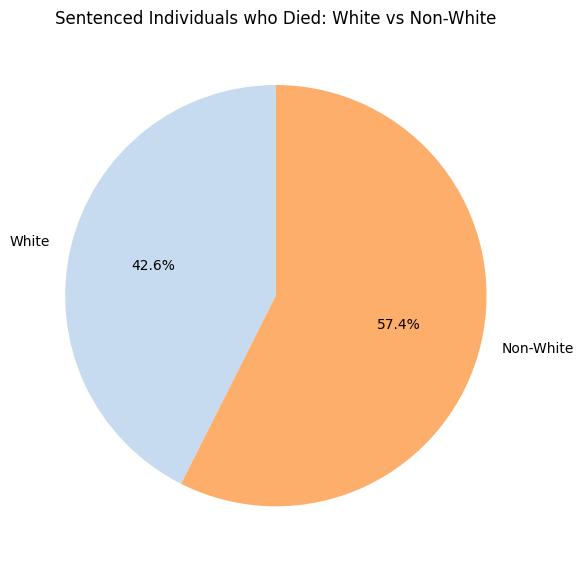

In [75]:
sentenced_counts = ct_race_custody['Sentenced'] # get only the sentencing data from the death in custody data

# Separate 'White' and aggregate all others as 'Non-White' for bias demonstration purposes
white_count = sentenced_counts.get('White', 0) # create count of white race in dataset
non_white_count = sentenced_counts.drop('White', errors='ignore').sum() # collate all other races under a single label

# Create a new Series for the pie chart, for the two categories
pie_data = pd.Series({
    'White': white_count,
    'Non-White': non_white_count
})

# Plot the pie chart in a simple way
plt.figure(figsize=(6, 6))
pie_data.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#c6dbef', '#fdae6b'])
plt.title('Sentenced Individuals who Died: White vs Non-White')
plt.ylabel('')  # Remove y-axis label
plt.tight_layout()
plt.savefig("biased_chart.png", dpi=300)
plt.show()

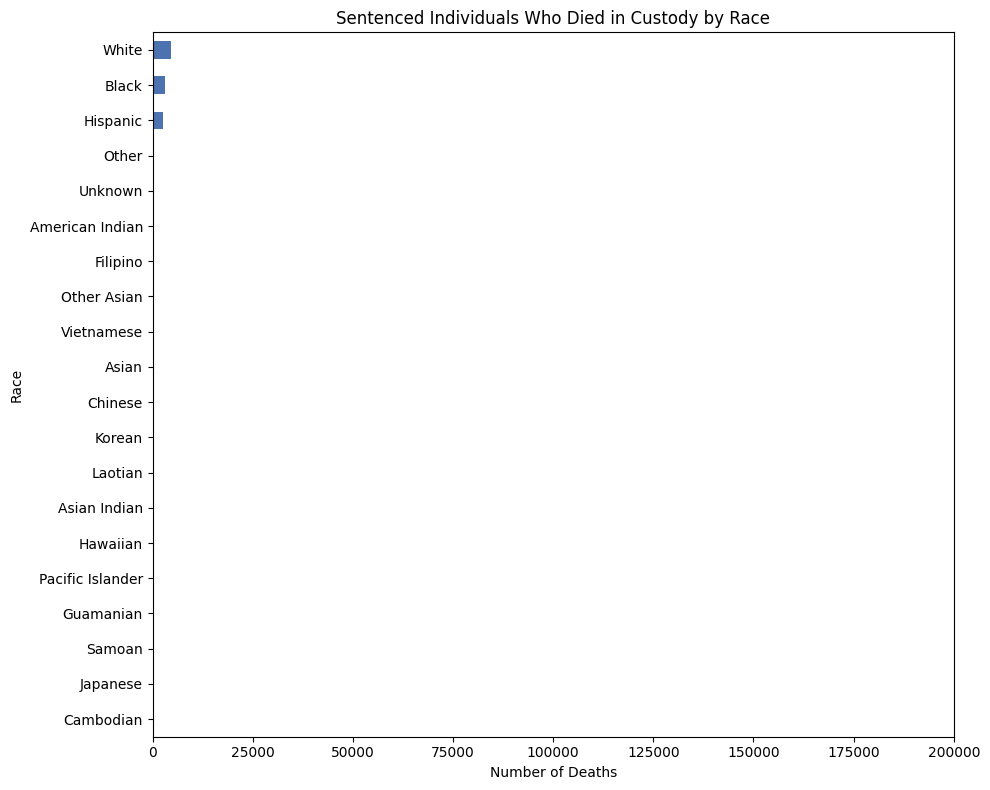

In [65]:
sentenced_counts = ct_race_custody['Sentenced'].sort_values(ascending=True)

# Plot a horizontal bar chart for clarity
plt.figure(figsize=(10, 8))
sentenced_counts.plot(kind='barh', color='#4C72B0')
plt.title('Sentenced Individuals Who Died in Custody by Race')
plt.xlabel('Number of Deaths')
plt.ylabel('Race')
plt.xlim(0, 200000)
plt.tight_layout()
plt.savefig("fair_chart.png", dpi=300)
plt.show()

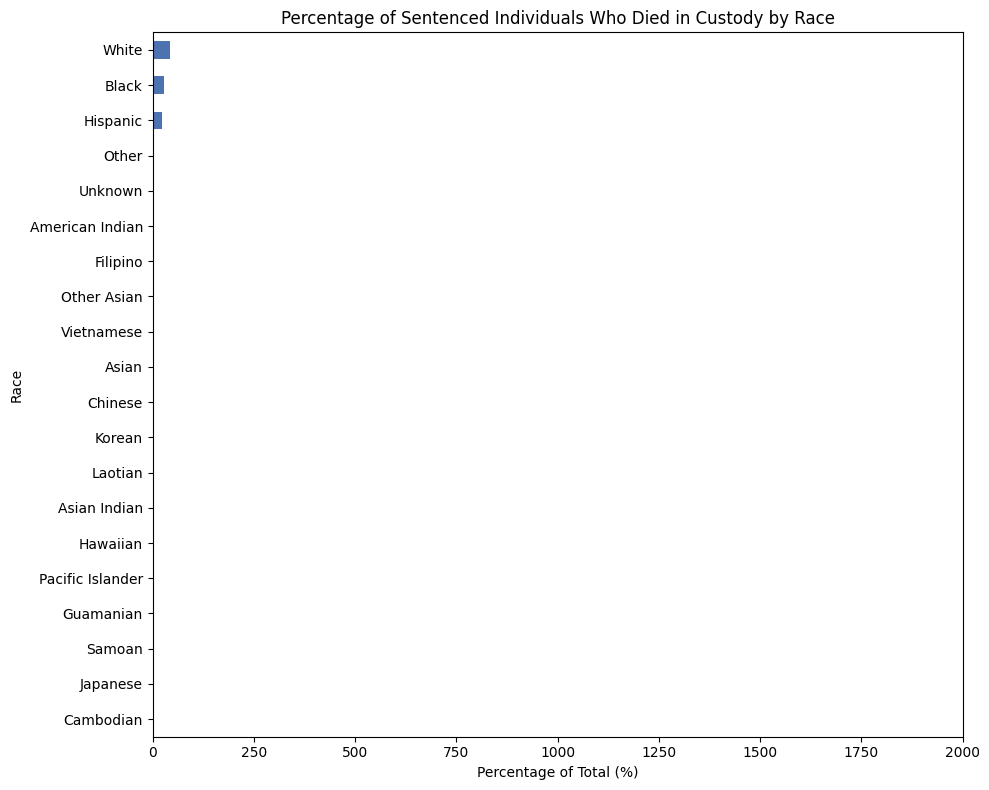

In [72]:
sentenced_counts = ct_race_custody['Sentenced']
sentenced_percent = (sentenced_counts / sentenced_counts.sum() * 100).sort_values(ascending=True)

# Plot a horizontal bar chart showing percentages
plt.figure(figsize=(10, 8))
sentenced_percent.plot(kind='barh', color='#4C72B0')
plt.title('Percentage of Sentenced Individuals Who Died in Custody by Race')
plt.xlabel('Percentage of Total (%)')
plt.ylabel('Race')
plt.xlim(0, 2000)
plt.tight_layout()
plt.savefig("fair_chart_percentage.png", dpi=300)
plt.show()

In [76]:
# Encode race as categorical numeric values
df['race_encoded_simple'] = df['race'].astype('category').cat.codes

# Full dataset statistics for race for comparison
race_mean_full_dataset = df['race_encoded_simple'].mean()
race_median_full_dataset = df['race_encoded_simple'].median()
race_mode_full_dataset = df['race_encoded_simple'].mode().iloc[0]

# Take 50% random sample for the sampled amount
df_random_sample_dataset = df.sample(frac=0.5, random_state=42)

# Sample dataset statistics for race computed
race_mean_sample_dataset = df_random_sample_dataset['race_encoded_simple'].mean()
race_median_sample_dataset = df_random_sample_dataset['race_encoded_simple'].median()
race_mode_sample_dataset = df_random_sample_dataset['race_encoded_simple'].mode().iloc[0]

# Print results for easy application to the final report
print("Step 5: Protected Class = Race (Encoded as numeric)")
print(f"{'':<20} {'Mean':<10} {'Median':<10} {'Mode':<10}")
print(f"{'Original Dataset':<20} {race_mean_full_dataset:<10.2f} {race_median_full_dataset:<10.2f} {race_mode_full_dataset:<10}")
print(f"{'Reduced Dataset':<20} {race_mean_sample_dataset:<10.2f} {race_median_sample_dataset:<10.2f} {race_mode_sample_dataset:<10}")
print(f"{'Difference':<20} {abs(race_mean_full_dataset - race_mean_sample_dataset):<10.2f} {abs(race_median_full_dataset - race_median_sample_dataset):<10.2f} {'Yes' if race_mode_full_dataset != race_mode_sample_dataset else 'No':<10}")


Step 5: Protected Class = Race (Encoded as numeric)
                     Mean       Median     Mode      
Original Dataset     11.66      9.00       19        
Reduced Dataset      11.63      9.00       19        
Difference           0.03       0.00       No        



Step 6: Frequency Table (Sample Dataset)
custody_status    Awaiting Booking  Other  Sentenced
race                                                
American Indian                  0     17         50
Asian                            0      8          8
Asian Indian                     0     10          5
Black                           27    640       1507
Cambodian                        0      5          2
Chinese                          0      8          8
Filipino                         0      9         28
Guamanian                        0      1          2
Hawaiian                         0      1          4
Hispanic                        34    792       1248
Japanese                         0      2          0
Korean                           0      5          6
Laotian                          0      3          3
Other                            0     25         62
Other Asian                      0     19         12
Pacific Islander                 0      9          5
Samo

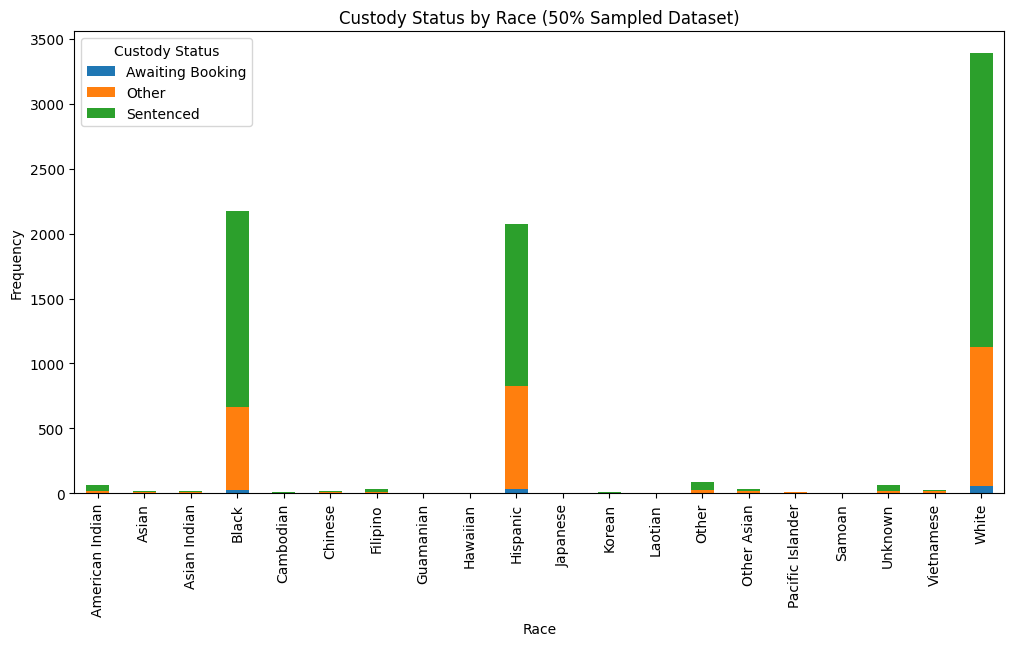

In [78]:
# Crosstab: race vs custody_status using reduced dataset
ct_race_custody_sample = pd.crosstab(df_sample['race'], df_sample['custody_status'])

# Frequency table
print("\nStep 6: Frequency Table (Sample Taken Dataset)")
print(ct_race_custody_sample)

# Histogram plot
ct_race_custody_sample.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Custody Status by Race (50% Sampled Dataset)')
plt.xlabel('Race')
plt.ylabel('Frequency')
plt.legend(title='Custody Status')
plt.tight_layout
plt.savefig("Sample_chart.png", dpi=300)
plt.show()